Define The Grid

In [1]:
import numpy as np
import pyvista as pv

nz_dims = 6
nxy_dims = 20

nz_ratio_dims = nz_dims + 1
nxy_ratio_dims = int(nxy_dims * 1)

xyz_dims = np.array([nxy_ratio_dims, nxy_ratio_dims, nz_ratio_dims])
xyz_dims_plus1 = [xyz_dims[0] + 1, xyz_dims[1] + 1, xyz_dims[2] + 1]

xyz_spacing = (nxy_dims / xyz_dims[0], nxy_dims / xyz_dims[1], 1)
xyz_grid = pv.UniformGrid(
    dims=xyz_dims_plus1,
    spacing=xyz_spacing,
    origin=(0, 0, 0),
)

xyz_points = np.transpose(xyz_grid.points.T)

Find contour points

In [2]:
import cv2 as cv
from matplotlib.path import Path
import matplotlib.patches as patches

names = [
    'sq-0001.png',
    'sq-0002.png',
    'sq-0003.png',
    'sq-0004.png',
    'sq-0005.png',
    'sq-0006.png',
]
input_path = 'images/sq-object'

stacked_contour_points = []
for name in names:
    image_memory = cv.imread(f'{input_path}/{name}')
    inverted_image = cv.bitwise_not(image_memory)
    img_gray = cv.cvtColor(inverted_image, cv.COLOR_BGR2GRAY)
    ret, thresh = cv.threshold(img_gray, 150, 255, cv.THRESH_BINARY)
    im2, contours, hierarchy = cv.findContours(image=thresh, mode=cv.RETR_TREE, method=cv.CHAIN_APPROX_NONE)

    multi_points = []
    for contour in contours:
        contour_points = contour[:, 0]
        path = Path(contour_points, closed=True)
        patch = patches.PathPatch(path, facecolor=None, lw=1, antialiased=True)
        vertices = patch.get_path().vertices
        trans = patch.get_patch_transform()
        points = trans.transform(vertices)
        multi_points.append(points)
    stacked_contour_points.append(multi_points)
stacked_contour_points.insert(0, [])
stacked_contour_points.append([])

Define point clouds

In [3]:
from shapely.geometry import Polygon, MultiPolygon, Point

object_index = []
xyz_points_object = []
for z in np.arange(0, xyz_dims_plus1[2], 1):
    multi_multipolygon = []
    for points in stacked_contour_points[z]:
        poly = Polygon(points)
        poly_big = poly.buffer(1e-6)
        if poly_big.geom_type == 'MultiPolygon':
            pass
        elif poly_big.geom_type == 'Polygon':
            poly_big = MultiPolygon([poly_big])
        else:
            pass
        multi_multipolygon.append(poly_big)

    for i, o in enumerate(np.array(list(filter(lambda c: c[2] == z, xyz_points)))):
        point = Point(o[:2])
        inserted = False
        for multipolygon in multi_multipolygon:
            if multipolygon.contains(point):
                xyz_points_object.append(o)
                inserted = True
                break
        object_index.append(1 if inserted else 0)


/Users/engineering/Documents/anaconda3/envs/shapely-pyvista/lib/python3.6/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


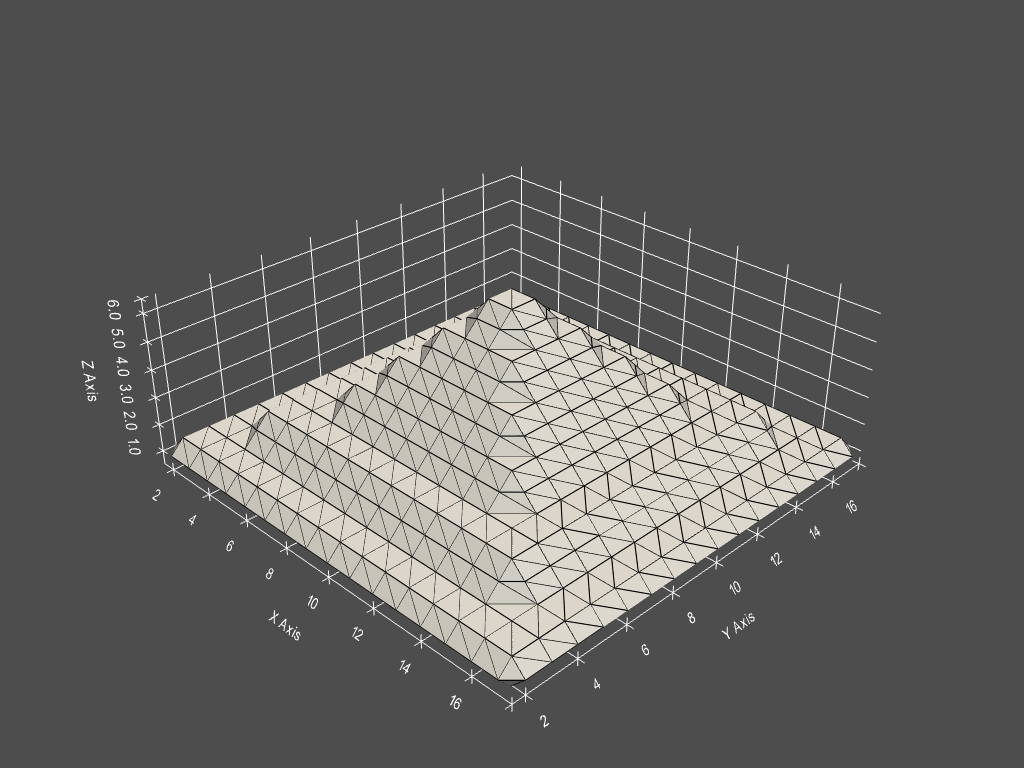

In [4]:
import math
import marching_3d_rules_minimal as rules

def num_digits(n):
    if n > 0:
        digits = int(math.log10(n)) + 1
    elif n == 0:
        digits = 1
    else:
        digits = int(math.log10(-n)) + 2
    return digits

dictionary = {}
points_p = []
faces_p = []

digit_x = 10 ** (num_digits(nxy_ratio_dims) + 1)
digit_y = 10 ** (num_digits(nxy_ratio_dims) + 1)

max_z = digit_x * digit_y
max_y = digit_x

cxy = xyz_dims[0] * xyz_dims[1]
cx = xyz_dims[0]
cxy_plus1 = xyz_dims_plus1[0] * xyz_dims_plus1[1]
cx_plus1 = xyz_dims_plus1[0]

for i in np.arange(0, np.prod(xyz_dims), 1, dtype=np.int):
    dz = i // cxy                                       # i div (dimension x and y) to get axis z
    dz_r = i - (dz * cxy)                               # get the remaining of dz
    dy = dz_r // cx                                     # remain of dz div (dimension of x) to get axis y
    dy_r = dz_r - (dy * cx)                             # get the remaining of dy
    dx = dy_r                                           # get the dx

    pt = dz * cxy_plus1 + dy * cx_plus1 + dx * 1        # mapping value to match array of points
    p0 = pt                                             # find the lowest x
    p1 = pt + 1                                         # find the lowest x + 1
    p2 = p0 + cx_plus1                                  # find the lowest x with y + 1
    p3 = p1 + cx_plus1                                  # find the lowest x + 1 with y + 1

    p4 = p0 + cxy_plus1
    p5 = p1 + cxy_plus1
    p6 = p2 + cxy_plus1
    p7 = p3 + cxy_plus1

    point_type = (object_index[p0] << 7) + (object_index[p1] << 6) + (object_index[p2] << 5) + (object_index[p3] << 4) + (object_index[p4] << 3) + (object_index[p5] << 2) + (object_index[p6] << 1) + (object_index[p7] << 0)
    point_group = [
        xyz_points[p0],
        xyz_points[p1],
        xyz_points[p2],
        xyz_points[p3],
        xyz_points[p4],
        xyz_points[p5],
        xyz_points[p6],
        xyz_points[p7],
    ]
    poly_points = rules.to_points(point_group, point_type)
    position = []
    for poly_point in poly_points:
        magnitude = poly_point[0] + (max_y * (poly_point[1] + 1)) + (max_z * (poly_point[2] + 1))
        if dictionary.get(magnitude) is None:
            points_p.append(poly_point)
            dictionary[magnitude] = len(points_p) - 1
        position.append(dictionary[magnitude])
    for poly_face in rules.to_faces(position, point_type):
        faces_p.append(poly_face)

polyline = pv.PolyData(points_p, faces=np.array(faces_p).flatten())

output_path = 'objs'
polyline.save(f'{output_path}/testing.stl')

plot = pv.Plotter()
plot.add_mesh(polyline, show_edges=True)
plot.camera_position = 'xy'
plot.show_bounds()
plot.show_grid()
plot.camera_position = 'yz'
plot.camera.azimuth = -45.0
plot.camera.elevation = 30.0
plot.show()